In [13]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import utils
from torchvision.models import list_models

## Load Data

In [2]:
data = torch.load("cat_vs_dog_data.pt")
labels = torch.load("cat_vs_dog_labels.pt").reshape((-1,1))

In [3]:
data.shape

torch.Size([25000, 3, 100, 100])

- data is transformed into 100x100 rgb images

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

In [5]:
# setting dataset for loader
class CatvsDogDataset(Dataset):
    def __init__(self, data, label, input_size):
        super().__init__()
        
        self.data = data / 255
        self.label = label
        self.input_size = input_size

    def __getitem__(self, index):
        # resize the image according to the models input size
        img_transform = transforms.Compose([transforms.Resize(input_size, antialias=True)
#                                             ,transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                           ])
        
        data_point = img_transform(self.data[index])
        data_label = self.label[index]
        
        return data_point, data_label

    def __len__(self):
        return self.data.shape[0]

## Train and Eval

In [6]:
def train(network, optimizer, loss_fn, train_loader, device):
    
    true_preds, num_preds = 0., 0.
    for train_inputs, train_labels in tqdm(train_loader):

        train_inputs = train_inputs.to(device)
        train_labels = train_labels.to(device)

        preds = network(train_inputs)
        
        loss = loss_fn(preds, train_labels.float())

        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        # finding and storing the train predictions to find accuracy
        with torch.no_grad():
            pred_labels = F.sigmoid(preds) > 0.5

            true_preds += (pred_labels == train_labels).sum()
            num_preds += train_labels.shape[0]

    accuracy = ((true_preds / num_preds) * 100).item()

    return accuracy, loss

def evalf(network, test_loader, device):
    
    model_preds = []
    true_labels = []
    eval_info = {}

    
    true_preds, num_preds = 0., 0.
    with torch.no_grad():
        for val_inputs, val_labels in tqdm(test_loader):

            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            
            preds = network(val_inputs)
            pred_labels = F.sigmoid(preds) > 0.5
            
            true_preds += (pred_labels == val_labels).sum()
            num_preds += val_labels.shape[0]

            model_preds += pred_labels.detach().cpu().numpy().astype(int).tolist()
            true_labels += val_labels.detach().cpu().numpy().tolist()
            
    accuracy = ((true_preds / num_preds) * 100).item()
    
    eval_info["accuracy"] = accuracy
    eval_info["model_preds"] = model_preds
    eval_info["true_labels"] = true_labels
    
    return eval_info

# Pretrained models in Pytorch

In [7]:
list_models()

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

## InceptionV3
- InceptionV3 takes 299x299 images as input

In [8]:
class InceptionV3Backboned(nn.Module):
    def __init__(self):
        super(InceptionV3Backboned, self).__init__()
        # Load pretrained InceptionV3
        self.inceptionv3 = torch.hub.load("pytorch/vision:v0.10.0", "inception_v3", weights="DEFAULT")
        
        # some other thing related with inception model
        self.inceptionv3.aux_logits = False

        # freezing the inception parameters
        for param in self.inceptionv3.parameters():
            param.requires_grad = False

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.bn1 = nn.BatchNorm1d(1000)
        self.linear1 = torch.nn.Linear(1000, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.linear2 = torch.nn.Linear(256, 1)

    def forward(self, x):


        x = self.inceptionv3(x)
        x = self.relu(self.bn1(x))
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.relu(self.bn2(x))
        x = self.dropout(x)
        x = self.linear2(x)

        return x

### Set Network Settings

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
epochs = 5
input_size = 299

inception_train_loader = DataLoader(CatvsDogDataset(X_train, y_train, input_size), batch_size=32, shuffle=True)
inception_test_loader = DataLoader(CatvsDogDataset(X_test, y_test, input_size), shuffle=False)

net = InceptionV3Backboned().to(device)
optimizer = optim.Adam(net.parameters())
criterion = nn.BCEWithLogitsLoss()

Using cache found in C:\Users\erdem/.cache\torch\hub\pytorch_vision_v0.10.0


### Training

In [10]:
train_accs = []
train_losses = []


net.train()

for e in range(epochs):
    acc, l = train(net, optimizer, criterion, inception_train_loader, device)

    train_accs.append(acc)
    train_losses.append(l)

    print(f"Epoch-{e+1}:")
    print(f"Train Accuracy: {acc}\nTrain Loss: {l}")

    
net.eval()    

evals = evalf(net, inception_test_loader, device)

100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [01:12<00:00,  7.58it/s]


Epoch-1:
Train Accuracy: 92.54857635498047
Train Loss: 0.05955461412668228


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [01:11<00:00,  7.69it/s]


Epoch-2:
Train Accuracy: 93.70857238769531
Train Loss: 0.15766069293022156


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [01:11<00:00,  7.68it/s]


Epoch-3:
Train Accuracy: 94.01142883300781
Train Loss: 0.17256680130958557


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [01:11<00:00,  7.68it/s]


Epoch-4:
Train Accuracy: 94.17143249511719
Train Loss: 0.17098277807235718


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [01:11<00:00,  7.68it/s]


Epoch-5:
Train Accuracy: 94.11428833007812
Train Loss: 0.15145321190357208


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [02:49<00:00, 44.14it/s]


Test Accuracy: 95.76000213623047


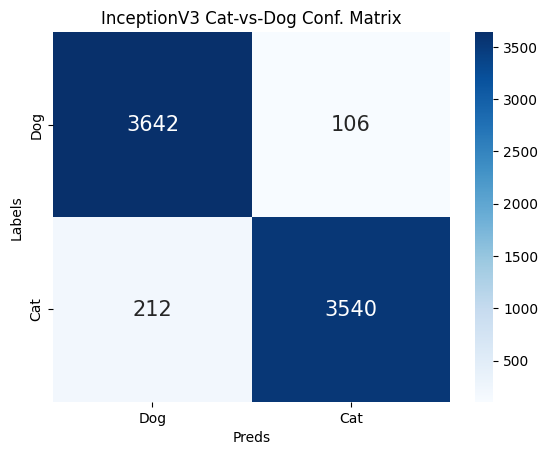

In [40]:
print(f"Test Accuracy: {evals['accuracy']}")

plt.figure()
sns.heatmap(confusion_matrix(evals["true_labels"], evals["model_preds"]),
            annot=True, fmt=".0f", cmap="Blues",
            annot_kws={"size":15},
            xticklabels=["Dog", "Cat"],
            yticklabels=["Dog", "Cat"])
plt.title("InceptionV3 Cat-vs-Dog Conf. Matrix")
plt.xlabel("Preds")
plt.ylabel("Labels")

plt.show()

## VGG19-BN

In [ ]:
vgg19_bn = torch.hub.load("pytorch/vision:v0.10.0", "vgg19_bn", weights="DEFAULT")